In [650]:

import praw
import pandas as pd
import requests
import json
import csv
import re
import string
import numpy as np
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

import spacy
import en_core_web_sm
from spacy.lang.en import English


In [651]:


from psaw import PushshiftAPI
api = PushshiftAPI()


In [3]:
# https://github.com/emilylorenzen/metis-unsupervised-nootropic_NLP/blob/main/metis-unsupervised-code.ipynb
api_request_generator = api.search_submissions(subreddit='blankies', score = ">18")
#api_request_generator = api.search_submissions(subreddit='blankies') -> 21211 entries but some are surely ads
# also want posts with user interaction

blankies_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [31]:
blankies_submissions.shape

(2070, 99)

In [6]:
blankies_submissions.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'author_fullname',
       'author_is_blocked', 'author_patreon_flair', 'author_premium',
       'awarders', 'can_mod_post', 'contest_mode', 'created_utc', 'domain',
       'full_link', 'gildings', 'id', 'is_created_from_ads_ui',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'retrieved_on', 'score', 'selftext', 'send_replies',
       'spoiler', 'stickied', 'subreddit', 'subreddit_id

In [5]:
blankies_submissions.to_csv('blankies.csv')

In [652]:
bl_subs = pd.read_csv('blankies.csv',header = 0,index_col=0,keep_default_na=False)

In [653]:
bl_subs.shape

(2070, 99)

In [654]:
bl_subs.title

0                    HE CAN’T KEEP GETTING AWAY WITH THIS
1                 When I click on yet another Marvel post
2       Letitia Wright Reportedly Continues Anti-Vacci...
3                            Graphic design is my passion
4                            Drew Barrymore &amp; Whip It
                              ...                        
2065                  I made Wonder Woman 10 times better
2066    Blank Check Podcast makes Vox's Top 11 Podcast...
2067                  Mail call! Let your voice be heard!
2068    Image of Griffin Newman's debut role in "Drill...
2069                      Some fan-art of #thetwofriends.
Name: title, Length: 2070, dtype: object

In [655]:
bl_subs.selftext

0                                                        
1                                                        
2                                                        
3                                                        
4       I’m hoping this was mentioned back when they c...
                              ...                        
2065                                                     
2066                                                     
2067                                                     
2068                                                     
2069                                                     
Name: selftext, Length: 2070, dtype: object

In [656]:
# https://github.com/emilylorenzen/metis-unsupervised-nootropic_NLP/blob/main/metis-unsupervised-code.ipynb

df_blan = bl_subs[['title', 'selftext']]
df_blan['body'] = df_blan.loc[:, ('title')] + ' ' + df_blan.loc[:, ('selftext')]
df_blan = df_blan.astype(str)
df_blan.body

/var/folders/cp/7qmpmnt105b1wpvjj8wd7r140000gp/T/ipykernel_43551/3213327188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blan['body'] = df_blan.loc[:, ('title')] + ' ' + df_blan.loc[:, ('selftext')]


0                   HE CAN’T KEEP GETTING AWAY WITH THIS 
1                When I click on yet another Marvel post 
2       Letitia Wright Reportedly Continues Anti-Vacci...
3                           Graphic design is my passion 
4       Drew Barrymore &amp; Whip It I’m hoping this w...
                              ...                        
2065                 I made Wonder Woman 10 times better 
2066    Blank Check Podcast makes Vox's Top 11 Podcast...
2067                 Mail call! Let your voice be heard! 
2068    Image of Griffin Newman's debut role in "Drill...
2069                     Some fan-art of #thetwofriends. 
Name: body, Length: 2070, dtype: object

In [657]:
# first pass at cleaning data
import contractions
import re
nlp = spacy.load('en_core_web_md')
def clean(row):
    
    clean_row = contractions.fix(row)
    clean_row = clean_row.replace('&amp','')
    clean_row = clean_row.replace('\n','')
    clean_row = clean_row.lower()
    clean_row = re.sub('[^a-zA-Z]',' ',clean_row)
    clean_row = clean_row.replace('  ',' ')
    
    words = ['podcast', 'https', 'com', 'newman', 'www','http','movie','film','check','amp','imgur','griffin','david','like','love',
            'episode','ben']
    for word in words:
        clean_row = clean_row.replace(word,'')

    clean_row = clean_row.replace('  ',' ')
    clean_row = clean_row.replace('  ',' ')


    return clean_row
    



In [658]:
#clean the input
array_blan =[]
for row in df_blan['body']:
    row = clean(row)
    array_blan.append(row)
    
#array_blan

In [659]:
#convert to series so can be used by tokenizers, etc.
ser_blan = pd.Series(array_blan)

In [660]:
#implement spaCy
docs_spaced = list(nlp.pipe(ser_blan))
docs_spaced[-3:]


[mail call let your voice be heard ,
 image of s debut role in drillbit taylor ,
 some fan art of thetwofriends ]

In [661]:
# use spaCy to remove stop words and punctuation
docs_spaced_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num) \
               or (w.lemma_=='not')] for doc in docs_spaced]

docs_list_clean = [' '.join(doc) for doc in docs_spaced_clean]
docs_list_clean[-3:]

['mail let voice hear',
 'image s debut role drillbit taylor',
 'fan art thetwofriend']

# CountVectorizer

In [662]:
#vectorize with CountVectorizer

cv = CountVectorizer(stop_words='english',ngram_range=(1,2),max_features=1000,max_df = .60)
# tried max_df at .75 and .6
Xtemp = cv.fit_transform(docs_list_clean)
#Xtemp = cv.fit_transform(doc_blan_bigrams)

df_Xtemp = pd.DataFrame(Xtemp.toarray(), columns=cv.get_feature_names())
df_Xtemp.head()

,able,absolute,absolutely,academy,account,act,action,actor,actress,actual,...,year,year ago,year old,yes,york,yoshida,young,youtu,youtube,youtube watch
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### SVD

In [663]:
# display words in topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [664]:
#try SVD as topic finder - 10 components
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(df_Xtemp)
lsa.explained_variance_ratio_

array([0.28106703, 0.09508925, 0.066376  , 0.04202348, 0.03205665,
       0.03038557, 0.02713173, 0.02081914, 0.01739438, 0.01521675])

In [665]:
# display words in topics
display_topics(lsa, cv.get_feature_names(), 5)


Topic  0
game, watch, youtube, youtube watch, play

Topic  1
feature, director, number, good, number feature

Topic  2
feature, number feature, number, age feature, age

Topic  3
set, brickset, millennium, falcon, brickset set

Topic  4
record, batman, big, director, charlie

Topic  5
record, batman, charlie, watch, big

Topic  6
star, good, war, star war, record

Topic  7
people, thing, way, think, star

Topic  8
lion, king, lion king, new, date

Topic  9
purchase, rental, purchase rental, available, place


### LDA

In [666]:
# LDA set up 
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(Xtemp)

# display LDA with CountVectorizer-vectorized documents
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, Xtemp, cv)

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.059232  0.014306       1        1  16.820909
5      0.045958 -0.000029       2        1  15.882189
4      0.074401 -0.062515       3        1  14.752073
2     -0.013022 -0.014012       4        1  10.714892
6      0.023746  0.026258       5        1   9.429638
8     -0.377917  0.008269       6        1   8.551439
7      0.017903 -0.062152       7        1   7.548499
9      0.032460 -0.175319       8        1   6.054808
1      0.088883  0.002561       9        1   5.720074
3      0.048356  0.262634      10        1   4.525478, topic_info=              Term        Freq       Total Category  logprob  loglift
326           game  178.000000  178.000000  Default  30.0000  30.0000
998        youtube  118.000000  118.000000  Default  29.0000  29.0000
999  youtube watch  105.000000  105.000000  Default  28.0000  28.0000
914        trailer   77.000000   77.000000  Default  27.0000  27.0000
957          watch  251.000000  251.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
97         blankie   15.452536  154.340091  Topic10  -4.4969   0.7941
498           live   11.339175   72.738342  Topic10  -4.8064   1.2368
111            boy   11.051639   67.534498  Topic10  -4.8321   1.2854
495         listen   10.806331   77.549764  Topic10  -4.8546   1.1247
957          watch    9.760075  251.337113  Topic10  -4.9564  -0.1530

[542 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3         5  0.966157        academy
7         1  0.304225          actor
7         3  0.045634          actor
7         4  0.015211          actor
7         5  0.532394          actor
...     ...       ...            ...
997       6  0.064766          youtu
998       6  0.981669        youtube
998       8  0.008463        youtube
999       6  0.979616  youtube watch
999       8  0.009511  youtube watch

[1515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 5, 3, 7, 9, 8, 10, 2, 4])

In [667]:
# try a different number of components in LDA
lda_tf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf.fit(Xtemp)
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, Xtemp, cv)

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.091396 -0.075814       1        1  32.890082
0      0.050075 -0.058341       2        1  28.199602
2     -0.292167 -0.014086       3        1  15.596894
1      0.089030 -0.124466       4        1  12.784292
3      0.061665  0.272706       5        1  10.529130, topic_info=              Term        Freq       Total Category  logprob  loglift
326           game  175.000000  175.000000  Default  30.0000  30.0000
525          march  126.000000  126.000000  Default  29.0000  29.0000
513        madness  122.000000  122.000000  Default  28.0000  28.0000
526  march madness  115.000000  115.000000  Default  27.0000  27.0000
998        youtube  115.000000  115.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
60       available   30.688487   95.863623   Topic5  -4.6552   1.1120
851          story   26.582856   89.195384   Topic5  -4.7989   1.0405
591            new   26.690054  205.180746   Topic5  -4.7948   0.2114
209            day   22.380177  109.830008   Topic5  -4.9710   0.6603
957          watch   22.633738  248.578456   Topic5  -4.9597  -0.1453

[316 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3         2  0.955042        academy
7         1  0.243516          actor
7         2  0.684888          actor
7         4  0.060879          actor
11        1  0.123544             ad
...     ...       ...            ...
995       1  0.944065        yoshida
997       3  0.955934          youtu
998       3  0.958620        youtube
998       5  0.034545        youtube
999       3  0.989796  youtube watch

[554 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])

### NMF

In [668]:
# try NMF on CountVectorize-vectorized data 
from sklearn.decomposition import NMF
nmf_model = NMF(5)
blankies_topic = nmf_model.fit_transform(Xtemp)
blankies_topic.shape


/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(2070, 5)

In [669]:
topic_word = nmf_model.components_
topic_word.shape

(5, 1000)

In [671]:
words = cv.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-150:-1]
topic_words = [[words[e] for e in l] for l in t]
#topic_words

In [672]:
# https://github.com/emilylorenzen/metis-unsupervised-nootropic_NLP/blob/main/metis-unsupervised-code.ipynb
#Create a wordclouds to identify words of interest to NMF
def create_wordcloud(wordcloud_series):
    df_text = ' '.join(str(wordcloud_series).lower() for v in wordcloud_series)
    wordcloud = WordCloud(stopwords = None, random_state = 20, background_color = 'white',
                      collocations=True).generate(df_text)
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()
    plt.savefig('wordcloud.png')

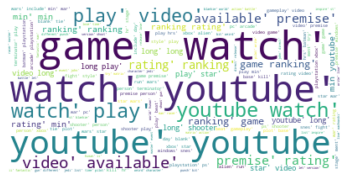

<Figure size 432x288 with 0 Axes>

In [673]:
create_wordcloud(topic_words[0])

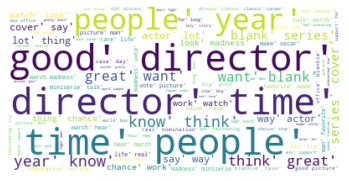

<Figure size 432x288 with 0 Axes>

In [674]:
create_wordcloud(topic_words[1])

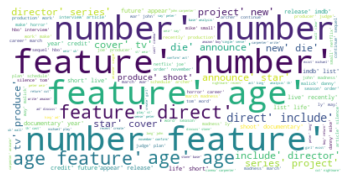

<Figure size 432x288 with 0 Axes>

In [675]:
create_wordcloud(topic_words[2])

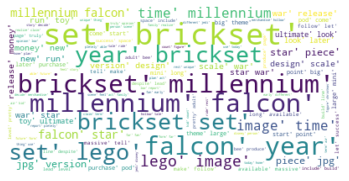

<Figure size 432x288 with 0 Axes>

In [623]:
create_wordcloud(topic_words[3])

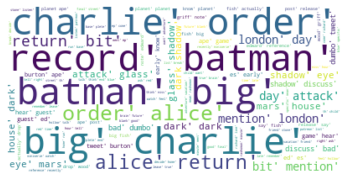

<Figure size 432x288 with 0 Axes>

In [676]:
create_wordcloud(topic_words[4])

# TFIDF

In [677]:
# set up tfidf vectorizer
cv_tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_features=1000,max_df=.75)
# tried max_df at .75 and .6
X_tfidf = cv_tfidf.fit_transform(docs_list_clean)



df_X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=cv_tfidf.get_feature_names())
df_X_tfidf.head()

,able,absolute,absolutely,academy,account,act,action,actor,actress,actual,...,year,year ago,year old,yes,york,yoshida,young,youtu,youtube,youtube watch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291718,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TFIDF SVD

In [678]:
# Try SVD on tfidf vectorized data
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(df_X_tfidf)
lsa.explained_variance_ratio_

array([0.006555  , 0.0124922 , 0.01194333, 0.00794458, 0.00739298,
       0.0067871 , 0.00631134, 0.00613952, 0.00602879, 0.00571724])

In [679]:
# display words in topics
display_topics(lsa, cv_tfidf.get_feature_names(), 5)


Topic  0
blank, think, march, madness, march madness

Topic  1
march, madness, march madness, round, vs

Topic  2
trailer, march madness, march, madness, round

Topic  3
man, gemini, gemini man, sim, look

Topic  4
blank, man, gemini, gemini man, sim

Topic  5
new, look, star, cast, director

Topic  6
vote, new, blankie, today, talk

Topic  7
look, vote, car, today, boy

Topic  8
look, blankie, new, think, blank

Topic  9
cast, pod, mann, think, director


### TFIDF LDA

In [680]:
# LDA on tfidf-vectorized data
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(X_tfidf)

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, X_tfidf, cv_tfidf)

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.068424 -0.018985       1        1  21.349584
0      0.027937  0.066785       2        1  13.813939
6     -0.001351  0.131414       3        1  10.564520
2      0.046899 -0.039305       4        1   9.457005
7     -0.190151 -0.019953       5        1   8.181460
4      0.056270 -0.182214       6        1   7.864958
8      0.064141  0.027557       7        1   7.571228
3     -0.147946  0.024167       8        1   7.282173
9     -0.010857 -0.090352       9        1   7.051179
1      0.086634  0.100885      10        1   6.863955, topic_info=        Term       Freq      Total Category  logprob  loglift
914  trailer  31.000000  31.000000  Default  30.0000  30.0000
522      man  23.000000  23.000000  Default  29.0000  29.0000
449    joker  11.000000  11.000000  Default  28.0000  28.0000
525    march  20.000000  20.000000  Default  27.0000  27.0000
332   gemini   9.000000   9.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
61    avatar   2.438256   6.183960  Topic10  -4.9376   1.7482
954     want   3.468630  17.249506  Topic10  -4.5851   1.0749
840     star   2.518214  19.700437  Topic10  -4.9053   0.6218
591      new   2.493896  30.864614  Topic10  -4.9150   0.1631
95     blank   2.285853  33.027522  Topic10  -5.0021   0.0083

[493 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         2  0.762506     absolutely
3         9  0.440742        academy
4         2  0.233570        account
4         5  0.700711        account
7         1  0.229018          actor
...     ...       ...            ...
994       4  0.918674           york
995      10  0.853938        yoshida
997       4  0.485702          youtu
998       1  0.794263        youtube
999       1  0.888782  youtube watch

[942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 3, 8, 5, 9, 4, 10, 2])

In [681]:
# LDA with different number of components
lda_tf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf.fit(X_tfidf)

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, X_tfidf, cv_tfidf)

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.067064 -0.042059       1        1  31.322322
4     -0.087367 -0.058987       2        1  20.319272
2      0.015522  0.193561       3        1  18.057304
1     -0.052014 -0.027516       4        1  17.705801
3      0.190924 -0.064999       5        1  12.595301, topic_info=        Term       Freq      Total Category  logprob  loglift
914  trailer  32.000000  32.000000  Default  30.0000  30.0000
449    joker  11.000000  11.000000  Default  29.0000  29.0000
141     cast  17.000000  17.000000  Default  28.0000  28.0000
525    march  20.000000  20.000000  Default  27.0000  27.0000
513  madness  19.000000  19.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
95     blank   9.128607  33.196902   Topic5  -4.2245   0.7808
591      new   7.275263  31.002893   Topic5  -4.4514   0.6222
518     make   4.971555  14.219253   Topic5  -4.8321   1.0210
111      boy   4.607850  12.075573   Topic5  -4.9081   1.1084
593     news   4.130881   9.207697   Topic5  -5.0174   1.2703

[280 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
4         2  0.696028        account
7         1  0.228498          actor
7         2  0.114249          actor
7         4  0.571246          actor
16        4  0.753312            age
...     ...       ...            ...
990       4  0.136771           year
990       5  0.045590           year
998       2  0.791812        youtube
998       4  0.158362        youtube
999       2  0.885160  youtube watch

[449 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

In [682]:
# try NMF on tfidf-vectorized data 
from sklearn.decomposition import NMF
nmf_model = NMF(5)
blankies_topic = nmf_model.fit_transform(X_tfidf)
blankies_topic.shape

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(2070, 5)

In [683]:
topic_word = nmf_model.components_
topic_word.shape

(5, 1000)

In [684]:
words = cv_tfidf.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-150:-1]
topic_words = [[words[e] for e in l] for l in t]
#topic_words

In [210]:
# https://github.com/emilylorenzen/metis-unsupervised-nootropic_NLP/blob/main/metis-unsupervised-code.ipynb
#Create a wordclouds to begin to identify words that will not provide a lot of value
def create_wordcloud(wordcloud_series):
    df_text = ' '.join(str(wordcloud_series).lower() for v in wordcloud_series)
    wordcloud = WordCloud(stopwords = None, random_state = 20, background_color = 'white',
                      collocations=True).generate(df_text)
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()
    plt.savefig('wordcloud.png')

/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tracker/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


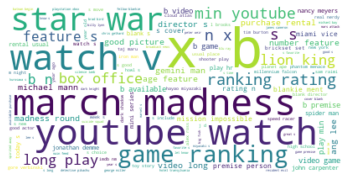

<Figure size 432x288 with 0 Axes>

In [685]:
#type(ser_blan)
create_wordcloud(docs_list_clean)
#plt.savefig('wordcloud.png')

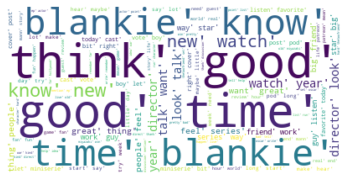

<Figure size 432x288 with 0 Axes>

In [686]:
create_wordcloud(topic_words[0])

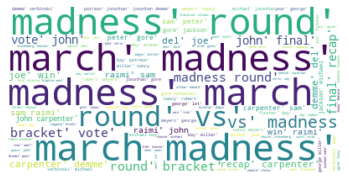

<Figure size 432x288 with 0 Axes>

In [687]:
create_wordcloud(topic_words[1])

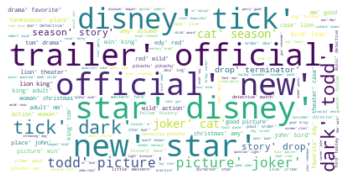

<Figure size 432x288 with 0 Axes>

In [688]:
create_wordcloud(topic_words[2])

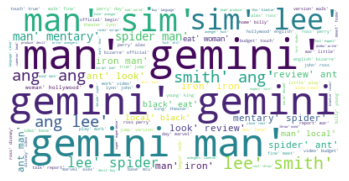

<Figure size 432x288 with 0 Axes>

In [689]:
create_wordcloud(topic_words[3])

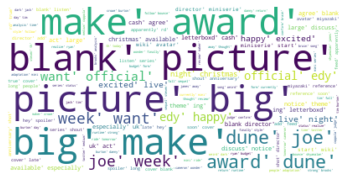

<Figure size 432x288 with 0 Axes>

In [690]:
create_wordcloud(topic_words[4])